## Objetivo de la tarea:
Predecir el costo del seguro médico de una persona

# PASO 1: Cargar datos

Ejecutar `pip install -r requirements.txt` desde la terminal

In [44]:
# importo librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
# cargo datos
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')

In [4]:
# info básica
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


El dataset contiene 1338 filas y 7 columnas.
Las variables son las siguientes:

**Independent variables**:

* age: age of primary beneficiary
* sex: insurance contractor gender, female or male
* bmi: Body mass index
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**Dependent variable (target)**:
* charges: Individual medical costs billed by health insurance

In [5]:
# guardo dataset original en carpeta raw
df_raw.to_csv('../data/raw/medical_insurance_cost.csv', index = False)

In [6]:
# separo en muestra de entrenamiento y evaluación para aplicar EDA solamente a entrenamiento
X = df_raw.drop(columns = 'charges', axis = 1)
y = df_raw['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1807)

In [7]:
# defino datset de entrenamiento (a aplicar EDA)
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.shape

(1070, 7)

# PASO 2: EDA

In [8]:
# miro tipos de variables
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 622 to 518
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


No hay valores nulos, hay que ver las categorías de las cualitativas

In [9]:
# paso a categóricas las de tipo objeto
cols = df_train.select_dtypes(include = ['object']).columns
for i in cols:
    df_train[i] = pd.Categorical(df_train[i])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 622 to 518
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1070 non-null   int64   
 1   sex       1070 non-null   category
 2   bmi       1070 non-null   float64 
 3   children  1070 non-null   int64   
 4   smoker    1070 non-null   category
 5   region    1070 non-null   category
 6   charges   1070 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 45.4 KB


In [10]:
# miro primeras filas
df_train.head()

age     sex     bmi  children smoker     region      charges
622    49  female  21.300         1     no  southwest   9182.17000
100    41  female  31.600         0     no  southwest   6186.12700
707    49    male  28.690         3     no  northwest  10264.44210
1277   32  female  29.735         0     no  northwest   4357.04365
974    26    male  35.420         0     no  southeast   2322.62180

In [11]:
# resumen numéricas
df_train.describe()

age          bmi     children       charges
count  1070.000000  1070.000000  1070.000000   1070.000000
mean     39.087850    30.744500     1.107477  13151.658484
std      14.004735     6.019095     1.218289  12066.681269
min      18.000000    16.815000     0.000000   1121.873900
25%      27.000000    26.400000     0.000000   4695.398637
50%      39.000000    30.495000     1.000000   9188.004250
75%      51.000000    34.792500     2.000000  16281.596250
max      64.000000    52.580000     5.000000  60021.398970

Los rangos de las variables son razonables, lo único que llama la atención es la variabilidad de la variable target, el mínimo es 1121 y el máximo 60021. Hay que ver si son atípicos los extremos superiores

In [12]:
# resumen categóricas
df_train.describe(include='category')

sex smoker     region
count     1070   1070       1070
unique       2      2          4
top     female     no  southeast
freq       535    855        297

In [13]:
df_train['sex'].value_counts()

female    535
male      535
Name: sex, dtype: int64

In [14]:
df_train['smoker'].value_counts()

no     855
yes    215
Name: smoker, dtype: int64

In [15]:
df_train['region'].value_counts()

southeast    297
southwest    265
northwest    256
northeast    252
Name: region, dtype: int64

Las categóricas tienen pocas categorías y no hay desconocidos

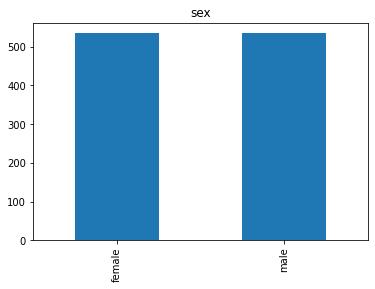

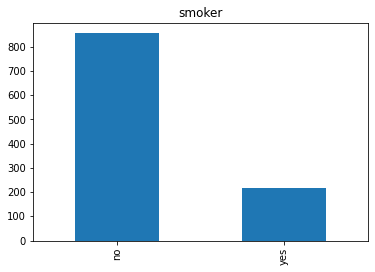

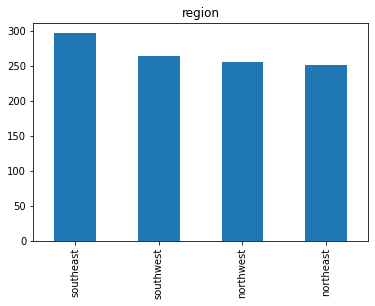

In [16]:
# gráficos univariados de las categóricas
cols = df_train.select_dtypes(include = ['category']).columns
for v in cols:
    df_train = df_train.sort_values(by=[v])
    df_train[v].value_counts().plot(kind = 'bar')
    plt.title(v)
    plt.show()

Sexo y región están balanceadas, smoke no (mayoría de "no").

Ahora se analiza la tariable target (charges)

<AxesSubplot:>

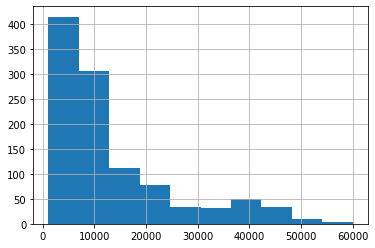

In [17]:
# analizamos variable target
df_train['charges'].hist()

La distribución se concentra en valores más cercanos al mínimo (está sesgada a la izquierda). Los valores superiores a 50000 son muy poco frecuentes

In [18]:
fig = px.box(df_train, y = "charges")
fig.show()

En este gráfico también se puede apreciar que los valores superiores a 50000 son muy pocos y se ven muy extremos

In [19]:
df_train[df_train['charges'] > 50000]

age     sex     bmi  children smoker     region      charges
577    31  female  38.095         1    yes  northeast  58571.07448
1230   52    male  34.485         3    yes  northwest  60021.39897
819    33  female  35.530         0    yes  northwest  55135.40209
34     28    male  36.400         1    yes  southwest  51194.55914
1146   60    male  32.800         0    yes  southwest  52590.82939

Son 5 las observaciones con charges > 50000, todos fumadores de edad y sexo variados pero todos con índice de masa corporal elevado, podrían ser casos raros pero válidos. En principio las mantengo.

Ahora voy a analizar la variable target en función de las cualitativas (una a una):

In [20]:
# charges según sexo
fig = px.box(df_train, x = "sex", y = "charges")
fig.show()

La distribución de charges es levemente superior para los hombres

In [21]:
# charges según region
fig = px.box(df_train, x = "region", y = "charges")
fig.show()

La distribución de charges es levemente superior para las regiones "northeast" y "southeast"

In [22]:
# charges según fumadores
fig = px.box(df_train, x = "smoker", y = "charges")
fig.show()

La distribución de charges es muy distinta según smoker, es muy superior para smoker = "yes" (los que fuman)

In [23]:
# charges según si tienen hijos
fig = px.box(df_train, x = "children", y = "charges")
fig.show()

La distribución de charges no varía demasiado según la cantidad de hijos, siendo levemente superior  para los que tienen entre 2 y 4 hijos. La distribución de los que tienen 5 hijos no sigue el comportamiento de las otras categorías, posiblemente porque sean pocos casos

In [24]:
df_train[df_train['children'] == 5]

age     sex     bmi  children smoker     region      charges
984    20    male  30.115         5     no  northeast   4915.05985
1116   41    male  29.640         5     no  northeast   9222.40260
71     31    male  28.500         5     no  northeast   6799.45800
438    52  female  46.750         5     no  southeast  12592.53450
1272   43    male  25.520         5     no  southeast  14478.33015
425    45    male  24.310         5     no  southeast   9788.86590
877    33    male  33.440         5     no  southeast   6653.78860
969    39  female  34.320         5     no  southeast   8596.82780
1130   39  female  23.870         5     no  southeast   8582.30230
32     19  female  28.600         5     no  southwest   4687.79700
413    25    male  23.900         5     no  southwest   5080.09600
1245   28    male  24.300         5     no  southwest   5615.36900
568    49  female  31.900         5     no  southwest  11552.90400
166    20  female  37.000         5     no  southwest   4830.63000
640    33    male  42.400         5     no  southwest   6666.24300
932    46    male  25.800         5     no  southwest  10096.97000
1085   39  female  18.300         5    yes  southwest  19023.26000

Hay 17 casos en df_train con 5 hijos

In [25]:
df_train['children'].value_counts()

0    456
1    259
2    192
3    127
4     19
5     17
Name: children, dtype: int64

Creo variable categórica a partir de cantidad de hijos: 0, 1, 2 o más


In [26]:
# agrupo cantidad de hijos
df_train['children_gr'] = pd.cut(df_train['children'], [-1,0,1,5], labels = ['0', '1', '2 o más'])
df_train['children_gr'].value_counts(sort = False)

0          456
1          259
2 o más    355
Name: children_gr, dtype: int64

In [27]:
# charges según categórica de hijos
fig = px.box(df_train, x = "children_gr", y = "charges", category_orders={"children_gr":['0', '1', '2 o más']})
fig.show()

Ahora análisis de las variables cuantitativas (univariado y multivariado)

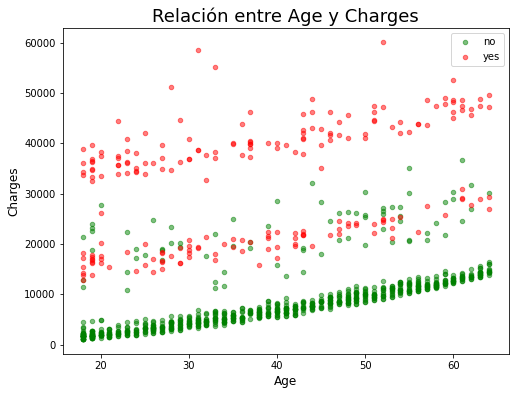

In [29]:
# scatter plot charges según edad, identificando con colores si fuma o no fuma
ax1 = df_train[df_train['smoker'] == 'no'].plot(kind = 'scatter', x = 'age', y = 'charges', color = 'green', alpha = 0.5, figsize = (8,6))
df_train[df_train['smoker'] == 'yes'].plot(kind = 'scatter', x = 'age', y = 'charges', color = 'red', alpha = 0.5, figsize = (8,6), ax = ax1)
plt.legend(labels = ['no', 'yes'])
plt.title('Relación entre Age y Charges', size = 18)
plt.xlabel('Age', size = 12)
plt.ylabel('Charges', size = 12);


Se puede apreciar una relación positiva entre age y charges, sobre todo al cruzar con la variable smoker, es decir, entre los que fuman se aprecia una relaciópn positiva (aumenta age y aumenta charges), lo mismo ocurre entre los que no fuman

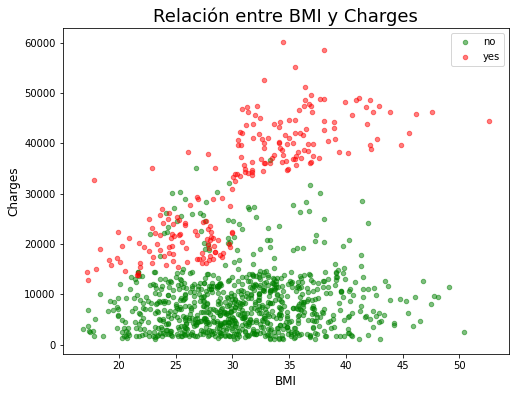

In [30]:
# scatter plot charges según BMI, identificando con colores si fuma o no fuma
ax1 = df_train[df_train['smoker'] == 'no'].plot(kind = 'scatter', x = 'bmi', y = 'charges', color = 'green', alpha = 0.5, figsize = (8,6))
df_train[df_train['smoker'] == 'yes'].plot(kind = 'scatter', x = 'bmi', y = 'charges', color = 'red', alpha = 0.5, ax=ax1)
plt.legend(labels = ['no', 'yes'])
plt.title('Relación entre BMI y Charges', size = 18)
plt.xlabel('BMI', size = 12)
plt.ylabel('Charges', size = 12);

En este caso se aprecia una relación positiva entre BMI y charges sobre todo entre los fumadores, no es tan clara la relación entre los no fumadores

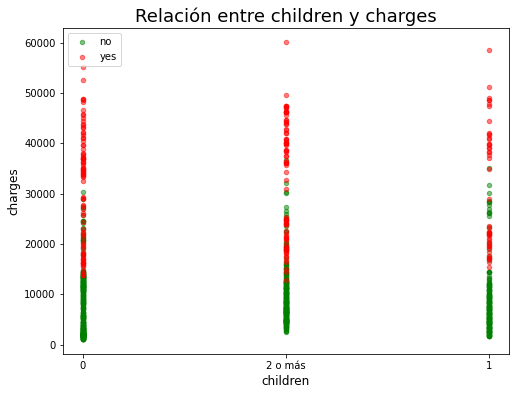

In [34]:
# scatter plot charges según children, identificando con colores si fuma o no fuma
ax1 = df_train[df_train['smoker'] == 'no'].plot(kind = 'scatter', x = 'children_gr', y = 'charges', color = 'green', alpha = 0.5, figsize = (8,6))
df_train[df_train['smoker'] == 'yes'].plot(kind = 'scatter', x = 'children_gr', y = 'charges', color = 'red', alpha = 0.5, ax = ax1)
plt.legend(labels = ['no', 'yes'])
plt.title('Relación entre children y charges', size=18)
plt.xlabel('children', size=12)
plt.ylabel('charges', size=12);

En este caso no se observa una relación clara, la cantidad de hijos no parece afectar tanto la variable target.

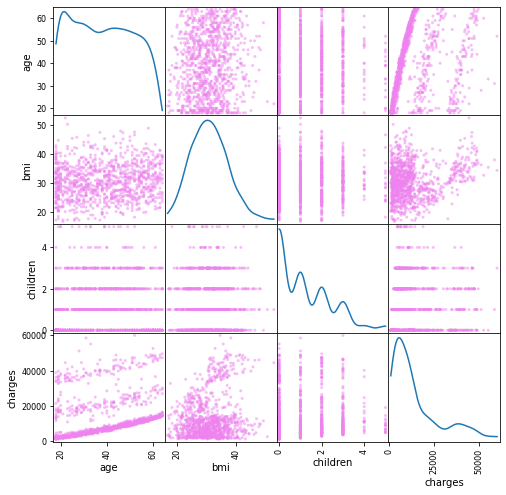

In [36]:
# scatter plot dos a dos
pd.plotting.scatter_matrix(df_train, diagonal = 'kde', figsize = (8,8), c = 'Violet')
plt.show()

Las variables numéricas que parecen más relacionadas a charges son age y BMI

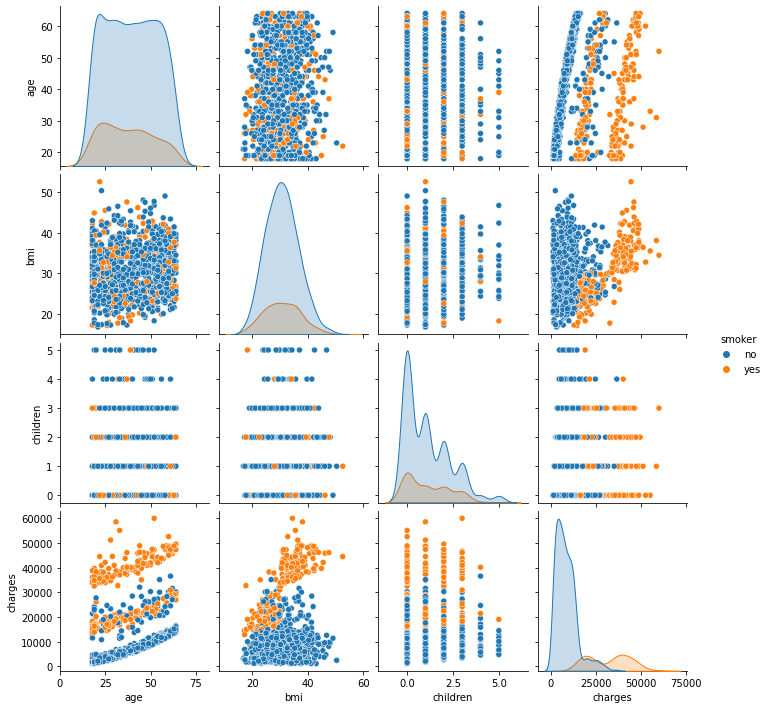

In [38]:
# scatter plot considerando variable smoker
sns.pairplot(data = df_train, hue = 'smoker')
plt.show()

La variable smoker afecta todas las distribuciones.

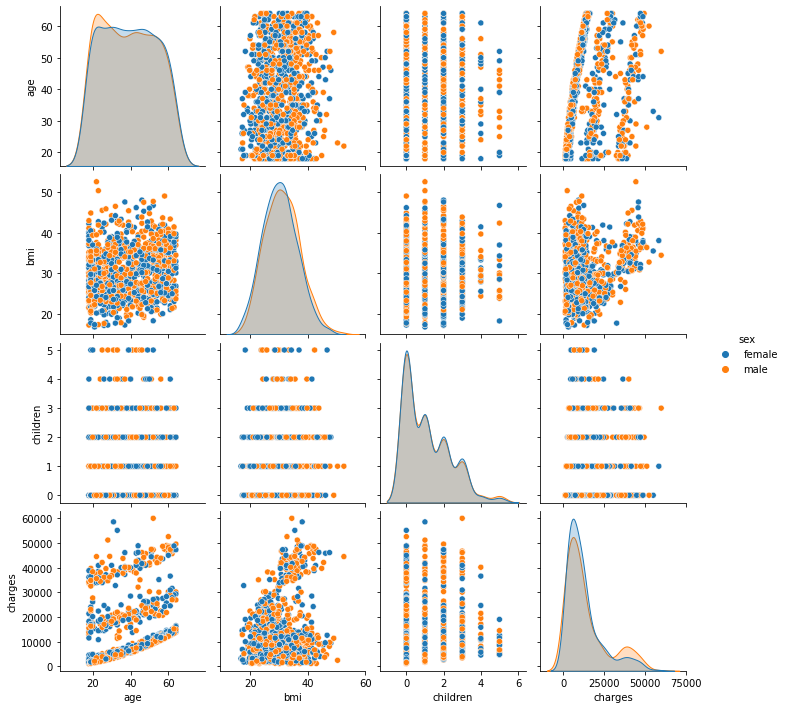

In [39]:
# scatter plot considerando variable sex
sns.pairplot(data = df_train, hue = 'sex')
plt.show()

La variable sex no parece afectar sustancialmente ninguna de las distribuciones

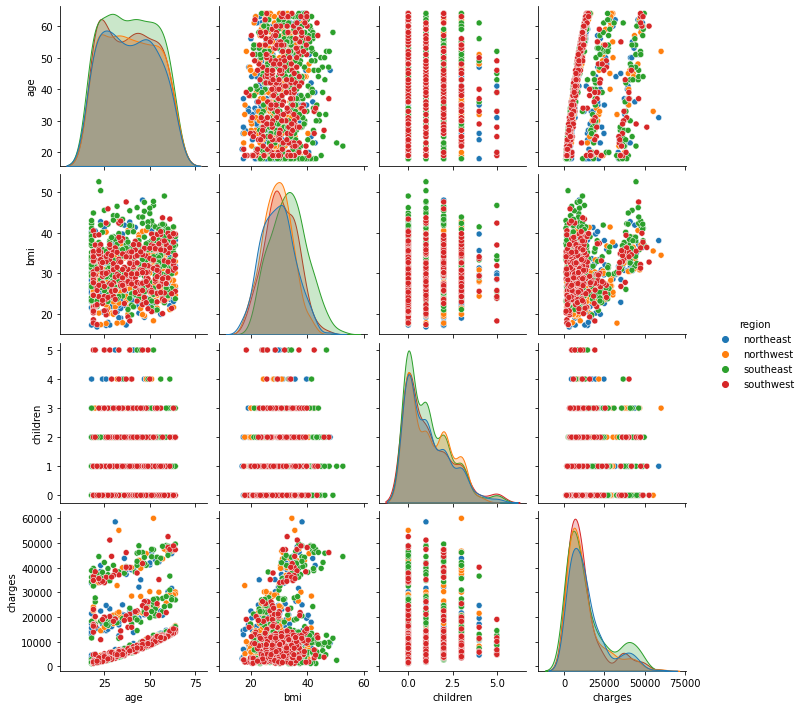

In [40]:
# scatter plot considerando variable region
sns.pairplot(data = df_train, hue = 'region')
plt.show()

La region tampoco parece influir sustancialmente en las demás distribuciones

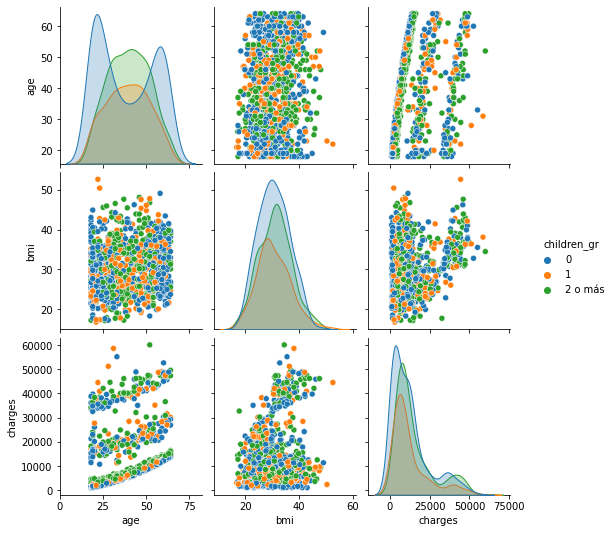

In [42]:
# scatter plot considerando variable children_gr
sns.pairplot(data = df_train.drop(columns = 'children', axis = 1), hue = 'children_gr')
plt.show()

La variable children_gr (creada a partir de children) parece afectar levemente las distribuciones 

Ahora estimo las correlaciones entre numéricas

<AxesSubplot:>

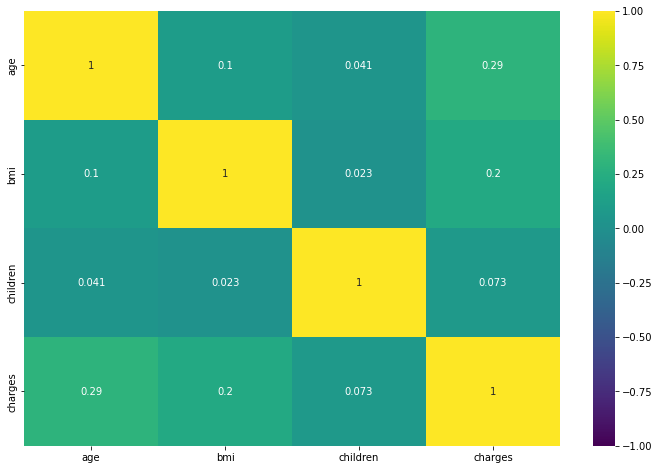

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(), annot = True, cmap = 'viridis', vmax = 1, vmin = -1, center = 0)

No hay alta correlación entre las variables cuantitativas. La variable más correlacionada con charges es age

In [52]:
# vuelvo a crear matriz X para actualizar variables
X_train = df_train.drop(columns = ['children', 'charges'], axis = 1) # saco target y numérica de hijos, dejo la categórica

# STEP 3: Estimación del modelo

In [53]:
# creo pipeline para preprocesamiento
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(include='number').columns
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse=False))]) # para datos categoricos. OneHotEncoder, transf variables categoricas en numéricas. Para usar en Linear Regression
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols), ('cat', cat_transformer, cat_cols)])
encode_data = Pipeline(steps=[('preprocessor', preprocessor)]) # categorias en n-1 columnas


In [54]:
# ajusto modelo de regresión lineal
lreg = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
lreg.fit(X_train, y_train)
print(f'R^2 score:{lreg.score(X_train, y_train)}')

R^2 score:0.006361057753940136


Algo debe estar mal por el bajísimo R2!! Seguir acá

In [27]:
# re categorizo "sexo" en 0 y 1
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)



In [28]:
df.head()

age  sex     bmi  children smoker     region      charges
0   19    0  27.900         0    yes  southwest  16884.92400
1   18    1  33.770         1     no  southeast   1725.55230
2   28    1  33.000         3     no  southeast   4449.46200
3   33    1  22.705         0     no  northwest  21984.47061
4   32    1  28.880         0     no  northwest   3866.85520

In [29]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [32]:
# función para convertir región a numérico
def conv_region(region_name):
    if region_name == 'southwest':
        return 1
    elif region_name == 'southeast':
        return 2
    elif region_name == 'northwest':
        return 3
    elif region_name == 'northeast':
        return 4
    else:
        return 'región sin determinar'
    


In [33]:
df['region'] = df.apply(lambda x: conv_region(x['region']), axis=1)

In [34]:
df.head()

age  sex     bmi  children smoker  region      charges
0   19    0  27.900         0    yes       1  16884.92400
1   18    1  33.770         1     no       2   1725.55230
2   28    1  33.000         3     no       2   4449.46200
3   33    1  22.705         0     no       3  21984.47061
4   32    1  28.880         0     no       3   3866.85520

In [35]:
# re categorizo "smoker" en 0 y 1
df['smoker'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

In [36]:
df.head()

age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       1  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       3  21984.47061
4   32    1  28.880         0       0       3   3866.85520

## PASO 4

In [40]:
### modelo regresión lineal
X = df.drop(['charges'], axis=1)
y = df['charges']

In [43]:
# separo en muestras de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# estimo modelo
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [47]:
# veo los coeficientes
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -13031.743631303658
Coefficients: 
 [ 2.57056264e+02 -1.87914567e+01  3.35781491e+02  4.25091456e+02
  2.36478181e+04  2.71284266e+02]


In [48]:
X_train

age  sex     bmi  children  smoker  region
560    46    0  19.950         2       0       3
1285   47    0  24.320         0       0       4
1142   52    0  24.860         0       0       2
969    39    0  34.320         5       0       2
486    54    0  21.470         3       0       3
...   ...  ...     ...       ...     ...     ...
1095   18    0  31.350         4       0       4
1130   39    0  23.870         5       0       2
1294   58    1  25.175         0       0       4
860    37    0  47.600         2       1       1
1126   55    1  29.900         0       0       1

[1070 rows x 6 columns]

In [50]:
# ejemplo
edad = 33
sex = 1
bm = 22
children = 0
smoker = 1
region = 3

In [51]:
# predigo target (charges) según datos de ejemplo
print('Predicted prima : \n', regr.predict([[edad,sex,bm,children,smoker,region]]))


Predicted prima : 
 [27281.18530825]


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

